0823 
- 기존 코드 
- 스케일링 하지 않음. 
- test.wav 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample

In [2]:
uploaded_file_name = 'test.wav'
EXPECTED_SAMPLE_RATE = 44100 #44.1KHz

def convert_audio_for_model(user_file, output_file = 'converted_audio_file.wav'):
    audio = AudioSegment.from_file(user_file, format = "wav")
    audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
    audio.export(output_file, format="wav")
    return output_file

converted_audio_file = convert_audio_for_model(uploaded_file_name)

# Loading audio samples from the wav file : 
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# 오디오 정보 출력
duration = len(audio_samples)/sample_rate
print("data :", audio_samples)
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

data : [ 1025  3071  5121 ... -5628 -3588 -1534]
Sample rate: 44100 Hz
Total duration: 5.75s
Size of the input: 253440


count    253440.000000
mean          0.022727
std       13317.174470
min      -22273.000000
25%      -11454.500000
50%         127.000000
75%       11585.000000
max       22271.000000
Name: 0, dtype: float64
train_data :  [ 1.025  3.071  5.121 ... -5.628 -3.588 -1.534]


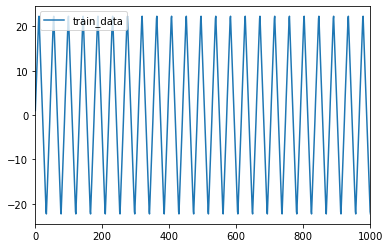

In [3]:
# csv파일 불러오기
pd.DataFrame(audio_samples).to_csv("test.csv")
data = pd.read_csv('test.csv')
train_data = data['0'].values/1000
# data 정보 출력
print(data['0'].describe())
print("train_data : ", train_data)
# train data 그래프 출력
plt.plot(train_data, label='train_data')
plt.xlim(0,1000)
plt.legend()
plt.show()

In [4]:
seq_len = 50  # 예측을 위한 데이터 수
prediction = 1  # 다음을 예측할 데이터 수
result = []
sequence_length = seq_len + prediction
for index in range(len(train_data) - sequence_length):
    result.append(train_data[index: index + sequence_length])
result = np.array(result)

In [1]:
# dataset 분할 
# 트레이닝할 값과 테스트 값을 나눠줌
row = int(round(result.shape[0] * 0.7))
train = result[:row, :]

X_train = train[:, :-prediction]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = train[:, -prediction]

X_test = result[row:, :-prediction]
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = result[row:, -prediction]

print("X_train : ", X_train.shape)
print("X_test : ", X_test.shape)

NameError: name 'result' is not defined

In [6]:
# 모델 생성
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50,1)))  # (timestep, feature)
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

# 트레이닝 값으로 학습
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=10, epochs=5)

# 모델 저장
model.save('weight.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
17738/17738 [==============================] - 475s 27ms/step - loss: 2.6375 - val_loss: 0.0655
Epoch 2/5
17738/17738 [==============================] - 471s 27ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 3/5
17738/17738 [==============================] - 476s 27ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 4/5
17738/17738 [==============================] - 523s 29

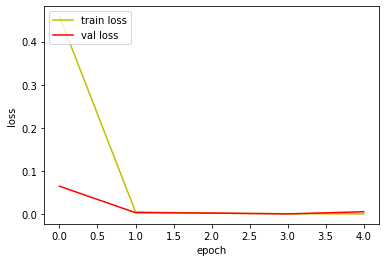

In [7]:
# 모델 학습 과정 표시
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')
plt.show()

In [8]:
# 모델 로드
model = Sequential()
model = load_model('weight.h5')

In [9]:
pred = model.predict(X_test)
pred

array([[15.856265 ],
       [13.830473 ],
       [11.782922 ],
       ...,
       [-7.4616256],
       [-5.276668 ],
       [-3.3670318]], dtype=float32)

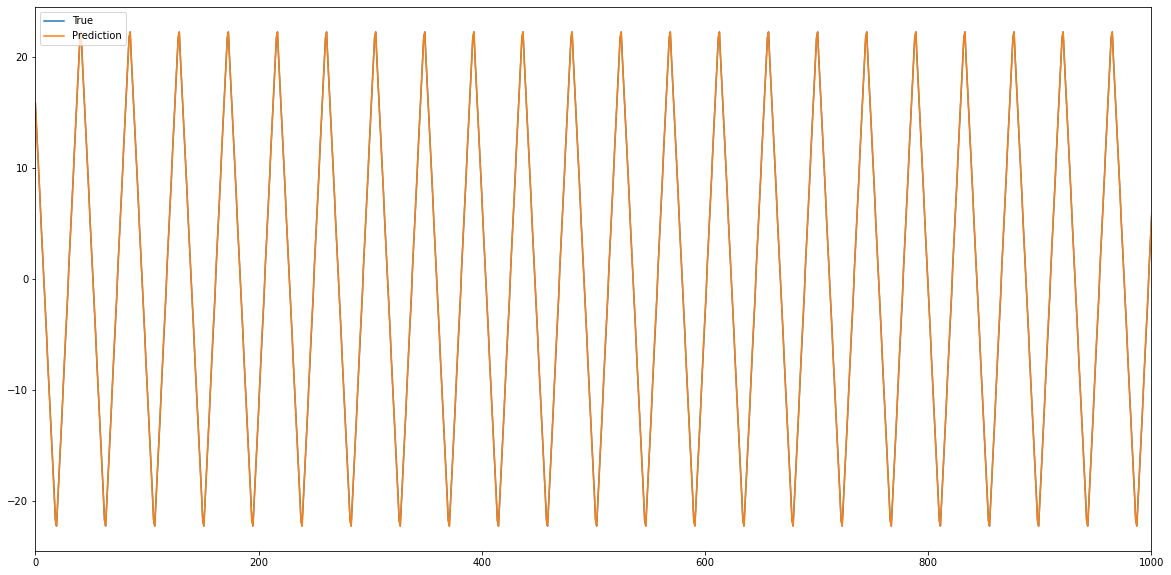

In [10]:
# 실제값과 예측값 그래프 출력
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.xlim(0,1000)
plt.show()

In [11]:
# 예측값을 wav로 출력
pred = pred * 1000 / EXPECTED_SAMPLE_RATE
wavfile.write("pred.wav", EXPECTED_SAMPLE_RATE, pred)
print("end")

end


In [12]:
pd.DataFrame(pred).to_csv("pred.csv")